# Project: Follow the money!
by: Arthur C. Avila

By using any information from this notebook, you agree to abide by the FEC rules on sale or use of contributor information detailed here: https://www.fec.gov/updates/sale-or-use-contributor-information/

* The code for this notebook is written in SAS.  

* The code to import the data into SAS datasets is at the end of this notebook because it is long and not interesting.


In [1]:
* sets library and raw data directory;
%let dirdata = /folders/myshortcuts/TDIProject/;
libname tdip "&dirdata";

SAS Connection established. Subprocess id is 3018



## Let's have a little peek at the last race for the Senate on Texas

In [2]:
* Find Beto and Cruz;
proc freq data=tdip.cn;
	table cand_id;
	where cand_name in ('CRUZ, RAFAEL EDWARD  TED' "O'ROURKE, ROBERT (BETO)");
run;

In [3]:
* Find Committees;
proc print data=tdip.ccl;
	where cand_id in ('S2TX00312' 'S8TX00285');
run;

Obs,CAND_ID,CAND_ELECTION_YR,FEC_ELECTION_YR,CMTE_ID,CMTE_TP,CMTE_DSGN,LINKAGE_ID
6244,S2TX00312,2018,2018,C00492785,S,P,216156
6245,S2TX00312,2018,2018,C00542423,N,J,216157
6246,S2TX00312,2018,2018,C00689471,S,J,221937
6247,S2TX00312,2018,2018,C00676676,S,J,220536
7123,S8TX00285,2018,2018,C00660639,S,J,218585
7124,S8TX00285,2018,2018,C00501197,S,P,217675


CMTE_DSGN = P means it is the candidate's primary committee. J designates a joint. Let's stick with the primary only for now.

In [ ]:
* creates summary tables looking only at types of entities;
proc sql;
	create table tdip.indirectsummary as
	select CMTE_ID, ENTITY_TP,
			sum(TRANSACTION_AMT) as indirect_money format dollar24.2
		from tdip.itcont
		group by CMTE_ID, ENTITY_TP;
		
	create table tdip.directsummary as
	select CMTE_ID, cand_id, ENTITY_TP,
			sum(TRANSACTION_AMT) as Money_to_Candidate format dollar24.2
		from tdip.itpas2 
		group by CMTE_ID, cand_id, ENTITY_TP;
quit;

* set missing entities to N/A to help with graphs;
data indirect;
	set tdip.indirectsummary;
	if ENTITY_TP = "" then ENTITY_TP = "N/A";
run;

data direct;
	set tdip.directsummary;
	if ENTITY_TP = "" then ENTITY_TP = "N/A";
run;

In [6]:
proc sql;
	create table texas_senate_cand as
	select cn.CAND_ID, 
		   cn.CAND_NAME as CName, 
		   sum(pas2.Money_to_Candidate) as Money_to_Candidate 
		   		label 'Contribution to Candidate'
		   		format dollar24.2,
		   pas2.ENTITY_Tp
	from tdip.cn as cn
	right join (
		select * from direct) as pas2
	on cn.cand_id = pas2.cand_id
	where cn.cand_id in ("S8TX00285", 'S2TX00312')
	group by cn.cand_id, CName, pas2.entity_tp
	order by CName, ENTITY_Tp;
quit;

	
proc sql;
	create table texas_senate_comm as
	select cm.CMTE_ID, 
		   cm.CMTE_NM as CName, 
		   ind.indirect_money as indirect_money,
		   ind.ENTITY_Tp
	from tdip.cm as cm 
	right join (
		select * from indirect) as ind
	on cm.cmte_id = ind.cmte_id
	where cm.CMTE_ID in ("C00501197", 'C00492785')
	order by cname, ENTITY_Tp;
quit;


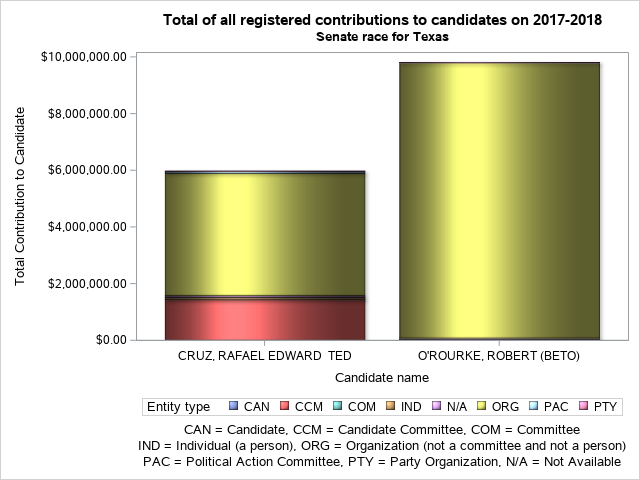
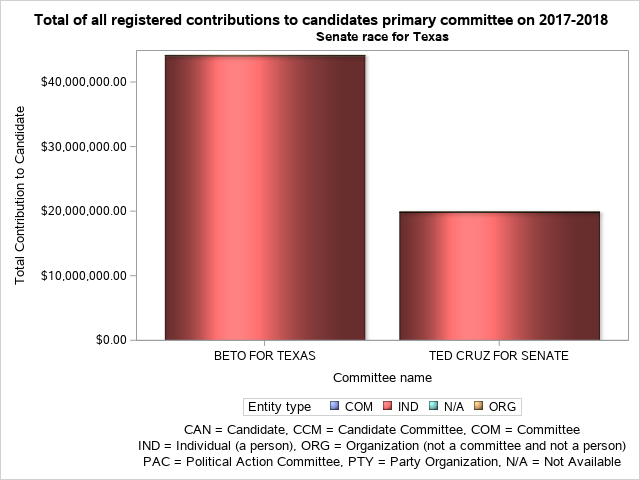

In [7]:
Title "Total of all registered contributions to candidates on 2017-2018";
Title2 "Senate race for Texas";
Footnote "CAN = Candidate, CCM = Candidate Committee, COM = Committee";
Footnote2 "IND = Individual (a person), ORG = Organization (not a committee and not a person)";
footnote3 "PAC = Political Action Committee, PTY = Party Organization, N/A = Not Available";
proc sgplot data=texas_senate_cand;
	vbar cname /  dataskin=sheen 
				  group = entity_tp 
				  freq=Money_to_candidate;
	yaxis label="Total Contribution to Candidate"
		  valuesformat=dollar24.2;
run;

Title "Total of all registered contributions to candidates primary committee on 2017-2018";
Title2 "Senate race for Texas";
proc sgplot data=texas_senate_comm;
	vbar cname / dataskin=sheen 
				  group = entity_tp 
				  freq=indirect_money;
	yaxis label="Total Contribution to Candidate"
		  valuesformat=dollar24.2;
run;

A couple of different insights come from these graphs. 
 * Most registered contributions to the candidates primary committees are made by individuals (that comes from the largest table of data as well).  
 * Ted Cruz received a significant share of contributions from "Candidate Committee's", which may  not be his own.  
 * Beto received a lot more money from non-individuals than Ted Cruz.  

In [ ]:


proc format cntlout=tdip.formats;
	value $ICIF 'C' = 'Challenger'
				'I' = 'Incumbent'
				'O' = 'Open Seat';
	value $officef	'H' = 'House'
					'P' = 'President'
					'S' = 'Senate';
	value $cstatusf 'C' = 'Statutory candidate'
					'F' = 'Statutory candidate for future election'
					'N' = 'Not yet a statutory candidate'
					'P' = 'Statutory candidate in prior cycle';
run;


data tdip.weball;
	infile "&dirdata.weball18.txt" dlm='|' dsd;
	input 
		CAND_ID :$9. 
		CAND_NAME :$200.
		CAND_ICI :$1.
		PTY_CD :$1.
		CAND_PTY_AFFILIATION :$3.
		TTL_RECEIPTS 
		TRANS_FROM_AUTH 
		TTL_DISB 
		TRANS_TO_AUTH 
		COH_BOP 
		COH_COP 
		CAND_CONTRIB 
		CAND_LOANS 
		OTHER_LOANS 
		CAND_LOAN_REPAY 
		OTHER_LOAN_REPAY 
		DEBTS_OWED_BY 
		TTL_INDIV_CONTRIB 
		CAND_OFFICE_ST :$2.
		CAND_OFFICE_DISTRICT :$2.
		SPEC_ELECTION	:$1.
		PRIM_ELECTION :$1.
		RUN_ELECTION :$1.
		GEN_ELECTION :$1.
		GEN_ELECTION_PRECENT
		OTHER_POL_CMTE_CONTRIB 
		POL_PTY_CONTRIB 
		CVG_END_DT	:MMDDYY10.
		INDIV_REFUNDS 
		CMTE_REFUNDS
	;
	label 
		CAND_ID =	'Candidate identification'
		CAND_NAME =	'Candidate name'
		CAND_ICI =	'Incumbent challenger status'
		PTY_CD =	'Party code'
		CAND_PTY_AFFILIATION =	'Party affiliation'
		TTL_RECEIPTS =	'Total receipts'
		TRANS_FROM_AUTH =	'Transfers from authorized committees'
		TTL_DISB =	'Total disbursements'
		TRANS_TO_AUTH =	'Transfers to authorized committees'
		COH_BOP =	'Beginning cash'
		COH_COP =	'Ending cash'
		CAND_CONTRIB =	'Contributions from candidate'
		CAND_LOANS =	'Loans from candidate'
		OTHER_LOANS =	'Other loans'
		CAND_LOAN_REPAY =	'Candidate loan repayments'
		OTHER_LOAN_REPAY =	'Other loan repayments'
		DEBTS_OWED_BY =	'Debts owed by'
		TTL_INDIV_CONTRIB =	'Total individual contributions'
		CAND_OFFICE_ST =	'Candidate state'
		CAND_OFFICE_DISTRICT =	'Candidate district'
		SPEC_ELECTION =	'Special election status'
		PRIM_ELECTION =	'Primary election status'
		RUN_ELECTION =	'Runoff election status'
		GEN_ELECTION =	'General election status'
		GEN_ELECTION_PRECENT =	'General election percentage'
		OTHER_POL_CMTE_CONTRIB =	'Contributions from other political committees'
		POL_PTY_CONTRIB =	'Contributions from party committees'
		CVG_END_DT =	'Coverage end date'
		INDIV_REFUNDS =	'Refunds to individuals'
		CMTE_REFUNDS =	'Refunds to committees'
	;
	format 	cvg_end_dt MMDDYY10.
			cand_ici $icif.
	;
run;

data tdip.cn;
	infile "&dirdata.cn.txt" dlm='|' dsd;
	input 
		CAND_ID :$9.
		CAND_NAME :$200.
		CAND_PTY_AFFILIATION :$3.
		CAND_ELECTION_YR
		CAND_OFFICE_ST :$2.
		CAND_OFFICE :$1.
		CAND_OFFICE_DISTRICT :$2.
		CAND_ICI :$1.
		CAND_STATUS :$1.
		CAND_PCC :$9.
		CAND_ST1 :$34.
		CAND_ST2 :$34.
		CAND_CITY :$30.
		CAND_ST :$2.
		CAND_ZIP :$9.
	;
	label 
		CAND_ID = 'Candidate identification'
		CAND_NAME = 'Candidate name'
		CAND_PTY_AFFILIATION = 'Party affiliation'
		CAND_ELECTION_YR = 'Year of election'
		CAND_OFFICE_ST = 'Candidate state'
		CAND_OFFICE = 'Candidate office'
		CAND_OFFICE_DISTRICT = 'Candidate district'
		CAND_ICI = 'Incumbent challenger status'
		CAND_STATUS = 'Candidate status'
		CAND_PCC = 'Principal campaign committee'
		CAND_ST1 = 'Mailing address - street'
		CAND_ST2 = 'Mailing address - street2'
		CAND_CITY = 'Mailing address - city'
		CAND_ST = 'Mailing address - state '
		CAND_ZIP = 'Mailing address - ZIP code'
	;
	format 
		CAND_OFFICE $officef.
		CAND_ICI $icif.
		CAND_STATUS $cstatusf.;
run;

data tdip.ccl;
	infile "&dirdata.ccl.txt" dlm='|' dsd;
	input 
		CAND_ID :$9.
		CAND_ELECTION_YR
		FEC_ELECTION_YR
		CMTE_ID :$9.
		CMTE_TP :$1.
		CMTE_DSGN :$1.
		LINKAGE_ID
	;
	label
		CAND_ID = 'Candidate identification'
		CAND_ELECTION_YR = 'Candidate election year'
		FEC_ELECTION_YR = 'FEC election year'
		CMTE_ID = 'Committee identification'
		CMTE_TP = 'Committee type'
		CMTE_DSGN = 'Committee designation'
		LINKAGE_ID = 'Linkage ID'
	;
run;

data tdip.webl;
	infile "&dirdata.webl18.txt" dlm='|' dsd;
	input 
		CAND_ID :$9.
		CAND_NAME :$200.
		CAND_ICI :$1.
		PTY_CD :$1.
		CAND_PTY_AFFILIATION :$3.
		TTL_RECEIPTS
		TRANS_FROM_AUTH
		TTL_DISB
		TRANS_TO_AUTH
		COH_BOP
		COH_COP
		CAND_CONTRIB
		CAND_LOANS
		OTHER_LOANS
		CAND_LOAN_REPAY
		OTHER_LOAN_REPAY
		DEBTS_OWED_BY
		TTL_INDIV_CONTRIB
		CAND_OFFICE_ST :$2.
		CAND_OFFICE_DISTRICT :$2.
		SPEC_ELECTION :$1.
		PRIM_ELECTION :$1.
		RUN_ELECTION :$1.
		GEN_ELECTION :$1.
		GEN_ELECTION_PRECENT
		OTHER_POL_CMTE_CONTRIB
		POL_PTY_CONTRIB
		CVG_END_DT :MMDDYY10.
		INDIV_REFUNDS
		CMTE_REFUNDS
	;
	label
		CAND_ID = 'Candidate identification'
		CAND_NAME = 'Candidate name'
		CAND_ICI = 'Incumbent challenger status'
		PTY_CD = 'Party code'
		CAND_PTY_AFFILIATION = 'Party affiliation'
		TTL_RECEIPTS = 'Total receipts'
		TRANS_FROM_AUTH = 'Transfers from authorized committees'
		TTL_DISB = 'Total disbursements'
		TRANS_TO_AUTH = 'Transfers to authorized committees'
		COH_BOP = 'Beginning cash'
		COH_COP = 'Ending cash'
		CAND_CONTRIB = 'Contributions from candidate'
		CAND_LOANS = 'Loans from candidate'
		OTHER_LOANS = 'Other loans'
		CAND_LOAN_REPAY = 'Candidate loan repayments'
		OTHER_LOAN_REPAY = 'Other loan repayments'
		DEBTS_OWED_BY = 'Debts owed by'
		TTL_INDIV_CONTRIB = 'Total individual contributions'
		CAND_OFFICE_ST = 'Candidate state'
		CAND_OFFICE_DISTRICT = 'Candidate district'
		SPEC_ELECTION = 'Special election status'
		PRIM_ELECTION = 'Primary election status'
		RUN_ELECTION = 'Runoff election status'
		GEN_ELECTION = 'General election status'
		GEN_ELECTION_PRECENT = 'General election percentage'
		OTHER_POL_CMTE_CONTRIB = 'Contributions from other political committees'
		POL_PTY_CONTRIB = 'Contributions from party committees'
		CVG_END_DT = 'Coverage end date '
		INDIV_REFUNDS = 'Refunds to individuals'
		CMTE_REFUNDS = 'Refunds to committees'
	;
run;

data tdip.cm;
	infile "&dirdata.cm.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		CMTE_NM :$200.
		TRES_NM :$90.
		CMTE_ST1 :$34.
		CMTE_ST2 :$34.
		CMTE_CITY :$30.
		CMTE_ST :$2.
		CMTE_ZIP :$9.
		CMTE_DSGN :$1.
		CMTE_TP :$1.
		CMTE_PTY_AFFILIATION :$3.
		CMTE_FILING_FREQ :$1.
		ORG_TP :$1.
		CONNECTED_ORG_NM :$200.
		CAND_ID :$9.
	;
	label 
		CMTE_ID = 'Committee identification'
		CMTE_NM = 'Committee name'
		TRES_NM = "Treasurer's name"
		CMTE_ST1 = 'Street one'
		CMTE_ST2 = 'Street two'
		CMTE_CITY = 'City or town'
		CMTE_ST = 'State'
		CMTE_ZIP = 'ZIP code'
		CMTE_DSGN = 'Committee designation'
		CMTE_TP = 'Committee type'
		CMTE_PTY_AFFILIATION = 'Committee party'
		CMTE_FILING_FREQ = 'Filing frequency'
		ORG_TP = 'Interest group category'
		CONNECTED_ORG_NM = "Connected organization's name"
		CAND_ID = 'Candidate identification'
	;
run;

data tdip.webk;
	infile "&dirdata.webk18.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		CMTE_NM :$200.
		CMTE_TP :$1.
		CMTE_DSGN :$1.
		CMTE_FILING_FREQ :$1.
		TTL_RECEIPTS
		TRANS_FROM_AFF
		INDV_CONTRIB
		OTHER_POL_CMTE_CONTRIB
		CAND_CONTRIB
		CAND_LOANS
		TTL_LOANS_RECEIVED
		TTL_DISB
		TRANF_TO_AFF
		INDV_REFUNDS
		OTHER_POL_CMTE_REFUNDS
		CAND_LOAN_REPAY
		LOAN_REPAY
		COH_BOP
		COH_COP
		DEBTS_OWED_BY
		NONFED_TRANS_RECEIVED
		CONTRIB_TO_OTHER_CMTE
		IND_EXP
		PTY_COORD_EXP
		NONFED_SHARE_EXP
		CVG_END_DT :MMDDYY10.
	;
	label 
		CMTE_ID = 'Committee identification'
		CMTE_NM = 'Committee name'
		CMTE_TP = 'Committee type'
		CMTE_DSGN = 'Committee designation'
		CMTE_FILING_FREQ = 'Committee filing frequency'
		TTL_RECEIPTS = 'Total receipts'
		TRANS_FROM_AFF = 'Transfers from affiliates'
		INDV_CONTRIB = 'Contributions from individuals'
		OTHER_POL_CMTE_CONTRIB = 'Contributions from other political committees'
		CAND_CONTRIB = 'Contributions from candidate'
		CAND_LOANS = 'Candidate loans'
		TTL_LOANS_RECEIVED = 'Total loans received'
		TTL_DISB = 'Total disbursements'
		TRANF_TO_AFF = 'Transfers to affiliates'
		INDV_REFUNDS = 'Refunds to individuals'
		OTHER_POL_CMTE_REFUNDS = 'Refunds to other political committees'
		CAND_LOAN_REPAY = 'Candidate loan repayments'
		LOAN_REPAY = 'Loan repayments'
		COH_BOP = 'Cash beginning of period'
		COH_COP = 'Cash close Of period'
		DEBTS_OWED_BY = 'Debts owed by'
		NONFED_TRANS_RECEIVED = 'Nonfederal transfers received'
		CONTRIB_TO_OTHER_CMTE = 'Contributions to other committees'
		IND_EXP = 'Independent expenditures'
		PTY_COORD_EXP = 'Party coordinated expenditures'
		NONFED_SHARE_EXP = 'Nonfederal share expenditures'
		CVG_END_DT = 'Coverage end date'
	;
run;

data tdip.itcont;
	infile "&dirdata.itcont.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		AMNDT_IND :$1.
		RPT_TP :$3.
		TRANSACTION_PGI :$5.
		IMAGE_NUM :$18.
		TRANSACTION_TP :$3.
		ENTITY_TP :$3.
		NAME :$200.
		CITY :$30.
		STATE :$2.
		ZIP_CODE :$9.
		EMPLOYER :$38.
		OCCUPATION :$38.
		TRANSACTION_DT :MMDDYY10.
		TRANSACTION_AMT
		OTHER_ID :$9.
		TRAN_ID :$32.
		FILE_NUM
		MEMO_CD :$1.
		MEMO_TEXT :$100.
		SUB_ID :19.
	;
	label
		CMTE_ID = 'Filer identification number'
		AMNDT_IND = 'Amendment indicator'
		RPT_TP = 'Report type'
		TRANSACTION_PGI = 'Primary-general indicator'
		IMAGE_NUM = 'Image number'
		TRANSACTION_TP = 'Transaction type'
		ENTITY_TP = 'Entity type'
		NAME = 'Contributor/Lender/Transfer Name'
		CITY = 'City'
		STATE = 'State'
		ZIP_CODE = 'ZIP code'
		EMPLOYER = 'Employer'
		OCCUPATION = 'Occupation'
		TRANSACTION_DT = 'Transaction date (MMDDYYYY)'
		TRANSACTION_AMT = 'Transaction amount'
		OTHER_ID = 'Other identification number'
		TRAN_ID = 'Transaction ID'
		FILE_NUM = 'File number / Report ID'
		MEMO_CD = 'Memo code'
		MEMO_TEXT = 'Memo text'
		SUB_ID = 'FEC record number'
	;
	format TRANSACTION_DT MMDDYY10.;
run;

data tdip.itpas2;
	infile "&dirdata.itpas2.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		AMNDT_IND :$1.
		RPT_TP :$3.
		TRANSACTION_PGI :$5.
		IMAGE_NUM :$18.
		TRANSACTION_TP :$3.
		ENTITY_TP :$3.
		NAME :$200.
		CITY :$30.
		STATE :$2.
		ZIP_CODE :$9.
		EMPLOYER :$38.
		OCCUPATION :$38.
		TRANSACTION_DT :MMDDYY8.
		TRANSACTION_AMT
		OTHER_ID :$9.
		CAND_ID :$9.
		TRAN_ID :$32.
		FILE_NUM
		MEMO_CD :$1.
		MEMO_TEXT :$100.
		SUB_ID
	;
	label
		CMTE_ID = 'Filer identification number'
		AMNDT_IND = 'Amendment indicator'
		RPT_TP = 'Report type'
		TRANSACTION_PGI = 'Primary-general indicator'
		IMAGE_NUM = 'Image number'
		TRANSACTION_TP = 'Transaction type'
		ENTITY_TP = 'Entity type'
		NAME = 'Contributor/lender/transfer Name'
		CITY = 'City'
		STATE = 'State'
		ZIP_CODE = 'ZIP code'
		EMPLOYER = 'Employer'
		OCCUPATION = 'Occupation'
		TRANSACTION_DT = 'Transaction date (MMDDYYYY)'
		TRANSACTION_AMT = 'Transaction amount'
		OTHER_ID = 'Other identification number'
		CAND_ID = 'Candidate ID'
		TRAN_ID = 'Transaction ID'
		FILE_NUM = 'File number / Report ID'
		MEMO_CD = 'Memo code'
		MEMO_TEXT = 'Memo text'
		SUB_ID = 'FEC record number'
	;
	format TRANSACTION_DT MMDDYY10.;
run;	

data tdip.itoth;
	infile "&dirdata.itoth.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		AMNDT_IND :$1.
		RPT_TP :$3.
		TRANSACTION_PGI :$5.
		IMAGE_NUM :$18.
		TRANSACTION_TP :$3.
		ENTITY_TP :$3.
		NAME :$200.
		CITY :$30.
		STATE :$2.
		ZIP_CODE :$9.
		EMPLOYER :$38.
		OCCUPATION :$38.
		TRANSACTION_DT :MMDDYY8.
		TRANSACTION_AMT
		OTHER_ID :$9.
		TRAN_ID :$32.
		FILE_NUM
		MEMO_CD :$1.
		MEMO_TEXT :$100.
		SUB_ID
	;
	* Original data 10191018 creates an error, best guess typo on year fix;
	IF _N_=920905 then TRANSACTION_DT = input("10192018",MMDDYY8.);
	label
		CMTE_ID = 'Filer identification number'
		AMNDT_IND = 'Amendment indicator'
		RPT_TP = 'Report type'
		TRANSACTION_PGI = 'Primary-general indicator'
		IMAGE_NUM = 'Image number'
		TRANSACTION_TP = 'Transaction type'
		ENTITY_TP = 'Entity type'
		NAME = 'Contributor/lender/transfer Name'
		CITY = 'City'
		STATE = 'State'
		ZIP_CODE = 'ZIP code'
		EMPLOYER = 'Employer'
		OCCUPATION = 'Occupation'
		TRANSACTION_DT = 'Transaction date (MMDDYYYY)'
		TRANSACTION_AMT = 'Transaction amount'
		OTHER_ID = 'Other identification number'
		TRAN_ID = 'Transaction ID'
		FILE_NUM = 'File number / Report ID'
		MEMO_CD = 'Memo code'
		MEMO_TEXT = 'Memo text'
		SUB_ID = 'FEC record number'
	;
	format TRANSACTION_DT MMDDYY10.;
run;
proc print data=tdip.itoth(firstobs=920904 obs=920906);
run;

data tdip.oppexp;
	infile "&dirdata.oppexp.txt" dlm='|' dsd;
	input 
		CMTE_ID :$9.
		AMNDT_IND :$1.
		RPT_YR
		RPT_TP :$3.
		IMAGE_NUM :$18.
		LINE_NUM :$4.
		FORM_TP_CD :$8.
		SCHED_TP_CD :$8.
		NAME :$200.
		CITY :$30.
		STATE :$2.
		ZIP_CODE :$9.
		TRANSACTION_DT :MMDDYY8.
		TRANSACTION_AMT
		TRANSACTION_PGI :$5.
		PURPOSE :$100.
		CATEGORY :$3.
		CATEGORY_DESC :$40.
		MEMO_CD :$1.
		MEMO_TEXT :$100.
		ENTITY_TP :$3.
		SUB_ID
		FILE_NUM 
		TRAN_ID :$32. 
		BACK_REF_TRAN_ID  :$32. 
	;
	label
		CMTE_ID = 'Filer identification number'
		AMNDT_IND = 'Amendment indicator'
		RPT_YR = 'Report year '
		RPT_TP = 'Report type'
		IMAGE_NUM = 'Image number'
		LINE_NUM = 'Line number'
		FORM_TP_CD = 'Form type'
		SCHED_TP_CD = 'Schedule type'
		NAME = 'Contributor/Lender/Transfer Name'
		CITY = 'City'
		STATE = 'State'
		ZIP_CODE = 'ZIP code'
		TRANSACTION_DT = 'Transaction date (MMDDYYYY)'
		TRANSACTION_AMT = 'Transaction amount'
		TRANSACTION_PGI = 'Primary general indicator'
		PURPOSE = 'Purpose'
		CATEGORY = 'Disbursement category code '
		CATEGORY_DESC = 'Disbursement Category Code Description'
		MEMO_CD = 'Memo code'
		MEMO_TEXT = 'Memo text'
		ENTITY_TP = 'Entity type'
		SUB_ID = 'FEC record number'
		FILE_NUM  = 'File number/report ID'
		TRAN_ID = 'Transaction ID'
		BACK_REF_TRAN_ID  = 'Back reference transaction ID'
	;
	format TRANSACTION_DT MMDDYY10.;
run;